In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# load inventory existences in distribution center in a dataframe
existences_2023 = pd.read_csv('concatenacion_existencias_cedis_2023.csv')

# load dataframe 2023 sales
complete_sales_2023 = pd.read_csv('ventas_ene_18mayo_2023.csv', low_memory=False)

# load average inventory in the company
global_average_inventory = pd.read_csv('concatenacion_existencias_global_2023.csv', low_memory=False)

In [3]:
# checking existences dataframe datatypes
existences_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365640 entries, 0 to 365639
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        365640 non-null  int64  
 1   REFERENCIA        365640 non-null  object 
 2   NOMBRE            365640 non-null  object 
 3   CATEGORIA         365640 non-null  object 
 4   C1                365640 non-null  object 
 5   C2                365640 non-null  object 
 6   C3                365640 non-null  object 
 7   C4                87163 non-null   object 
 8   UBICACIÓN         365640 non-null  object 
 9   COSTO             365640 non-null  float64
 10  CANTIDAD EN MANO  365640 non-null  int64  
 11  PE/VF             365640 non-null  int64  
 12  MAXIMO            365640 non-null  int64  
 13  MINIMO            365640 non-null  int64  
 14  REORDEN           365640 non-null  int64  
 15  IMPORTANCIA       236902 non-null  object 
 16  VALOR LOGISTICO   36

In [4]:
# checking sales dataframe datatypes
complete_sales_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95857 entries, 0 to 95856
Data columns (total 66 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AÑO                      95857 non-null  int64  
 1   Linea P                  95857 non-null  object 
 2   Cat Resumen              95857 non-null  object 
 3   REFERENCIA INTERNA       95857 non-null  object 
 4   CANTIDAD                 95857 non-null  int64  
 5   PRECIO UNITARIO          95857 non-null  object 
 6   COSTO UNITARIO           95857 non-null  object 
 7   VENTA                    95857 non-null  object 
 8   COSTO                    95857 non-null  object 
 9   MGN                      95857 non-null  float64
 10  CLIENTE                  95857 non-null  object 
 11  VENDEDOR                 95857 non-null  object 
 12  NUMERO DE DOCUMENTO      95857 non-null  object 
 13  TIPO DE DOCUMENTO        95857 non-null  object 
 14  FECHA                 

In [5]:
# select columns to transform
columns_to_convert = ['COSTO', 'PRECIO UNITARIO', 'COSTO UNITARIO', 'VENTA']

# replace some special characters in 'columns_to_convert'
for column in columns_to_convert:
    complete_sales_2023[column] = complete_sales_2023[column].replace({'\$': '', ',': ''}, regex=True).astype(float)

In [6]:
# checking the changes in sales dataframe datatypes
complete_sales_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95857 entries, 0 to 95856
Data columns (total 66 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AÑO                      95857 non-null  int64  
 1   Linea P                  95857 non-null  object 
 2   Cat Resumen              95857 non-null  object 
 3   REFERENCIA INTERNA       95857 non-null  object 
 4   CANTIDAD                 95857 non-null  int64  
 5   PRECIO UNITARIO          95857 non-null  float64
 6   COSTO UNITARIO           95857 non-null  float64
 7   VENTA                    95857 non-null  float64
 8   COSTO                    95857 non-null  float64
 9   MGN                      95857 non-null  float64
 10  CLIENTE                  95857 non-null  object 
 11  VENDEDOR                 95857 non-null  object 
 12  NUMERO DE DOCUMENTO      95857 non-null  object 
 13  TIPO DE DOCUMENTO        95857 non-null  object 
 14  FECHA                 

In [7]:
# average global inventory level
# select the columns
columns_average_inventory = global_average_inventory[['REFERENCIA', 'NOMBRE', 'C1', 'C2', 'C3', 'UBICACIÓN', 'MINIMO', 'VALOR FINANCIERO', 'PROVEEDOR', 'FECHA']]

# filter stock products
min_max_filter = columns_average_inventory[(columns_average_inventory['MINIMO'] > 0)]

# group by product and date, adding inventory amount
group_date = min_max_filter.groupby(by=['REFERENCIA', 'FECHA'], sort=False)['VALOR FINANCIERO'].sum().reset_index(name = 'INV_PROM')

# group by product and adding the average inventory for each product
average_inventory = group_date.groupby('REFERENCIA')['INV_PROM'].mean().reset_index(name = 'INV_PROM')

# round to two decimals
average_inventory['INV_PROM'] = average_inventory['INV_PROM'].round(2)
average_inventory


,REFERENCIA,INV_PROM
0,ABB-AF26300013,1439.17
1,ABB-MS11625,3679.83
2,ACE-ACEMIRE150L,49662.34
3,ACE-FRIOWF150L,38473.36
4,ACE-FRIOWF500G,2640.67
...,...,...
2622,ZON-RDS16,7319.78
2623,ZON-SPAD08,6690.56
2624,ZON-SPAD10,7137.88
2625,ZON-SPAD12,7458.21


In [8]:
# sales products in pieces and money
# rename some columns from sales dataframe
sales_2023 = complete_sales_2023[['SubC', 'Categoria', 'REFERENCIA INTERNA', 'CANTIDAD', 'COSTO UNITARIO', 'COSTO', 'VENTA', 'SUCURSAL', 'MES', 'Pe o Stock']].rename(columns={'REFERENCIA INTERNA':'REFERENCIA'})

# filter only stock sales
stock_sales_filter = sales_2023[(sales_2023['Pe o Stock'] == 'Stock')]

# group by product and adding the sum of quantity, product cost and amount of sale. Rename columns
group_sales_2023 = stock_sales_filter.groupby('REFERENCIA').agg({'CANTIDAD': 'sum', 'COSTO': 'sum', 'VENTA': 'sum'}).rename(columns={'COSTO':'COSTO_VENTA', 'VENTA': 'MONTO_VENTA'})

# create a utility column; amount sales minus cost sales
group_sales_2023['UTILIDAD'] = group_sales_2023['MONTO_VENTA'] - group_sales_2023['COSTO_VENTA']
group_sales_2023


,CANTIDAD,COSTO_VENTA,MONTO_VENTA,UTILIDAD
REFERENCIA,,,,
ABB-MS11620,1,1111.24,1.00,-1110.24
ACE-ACEMIRE150L,155,35579.38,41335.60,5756.22
ACE-ACEMIRE300L,19,3276.16,5438.74,2162.58
ACE-FRIOWF150L,330,40602.48,45056.11,4453.63
ACE-FRIOWF500G,12,4553.65,6007.80,1454.15
...,...,...,...,...
ZON-RDS10,18,34897.54,45761.00,10863.46
ZON-RDS12,8,16562.54,20665.00,4102.46
ZON-RDS14,1,2215.60,2722.00,506.40


In [15]:
# concat sales and average inventory tables to obtain rotation and GMROII for products
# merge last sales dataframe with average inventory dataframe and rename columns
merge_sales_inventory = pd.merge(group_sales_2023, average_inventory, on='REFERENCIA', how='left').rename(columns={'VALOR FINANCIERO':'INV_PROM', 'CANTIDAD':'VENTA_PZAS'})

# create rotation column
merge_sales_inventory['ROT'] = (merge_sales_inventory['COSTO_VENTA'] / merge_sales_inventory['INV_PROM']).round(1)

# create GMROII column
merge_sales_inventory['GMROII'] = (merge_sales_inventory['UTILIDAD'] / merge_sales_inventory['INV_PROM']).round(1)

# fill na values with 0
merge_sales_inventory.fillna(0, inplace=True)
merge_sales_inventory

,REFERENCIA,VENTA_PZAS,COSTO_VENTA,MONTO_VENTA,UTILIDAD,INV_PROM,ROT,GMROII
0,ABB-MS11620,1,1111.24,1.00,-1110.24,0.00,0.0,0.0
1,ACE-ACEMIRE150L,155,35579.38,41335.60,5756.22,49662.34,0.7,0.1
2,ACE-ACEMIRE300L,19,3276.16,5438.74,2162.58,0.00,0.0,0.0
3,ACE-FRIOWF150L,330,40602.48,45056.11,4453.63,38473.36,1.1,0.1
4,ACE-FRIOWF500G,12,4553.65,6007.80,1454.15,2640.67,1.7,0.6
...,...,...,...,...,...,...,...,...
2375,ZON-RDS10,18,34897.54,45761.00,10863.46,51321.70,0.7,0.2
2376,ZON-RDS12,8,16562.54,20665.00,4102.46,69199.77,0.2,0.1
2377,ZON-RDS14,1,2215.60,2722.00,506.40,84383.48,0.0,0.0
2378,ZON-RDS16,1,2356.83,2923.00,566.17,7319.78,0.3,0.1


In [17]:
# Selection of existences columns
columns = existences_2023[['REFERENCIA', 'CANTIDAD EN MANO', 'FECHA', 'MINIMO', 'MAXIMO', 'IMPORTANCIA', 'PROVEEDOR']]

In [18]:
# date and filter stock inventory products
stock_products = columns[(columns['MAXIMO'] > 0)].sort_values(['REFERENCIA', 'FECHA'])
stock_products

,REFERENCIA,CANTIDAD EN MANO,FECHA,MINIMO,MAXIMO,IMPORTANCIA,PROVEEDOR
6983,ACE-ACEMIRE150L,74,2023-01-02,57,75,A,ACEMIRE DE MEXICO SA DE CV
21018,ACE-ACEMIRE150L,74,2023-01-03,57,75,A,ACEMIRE DE MEXICO SA DE CV
35091,ACE-ACEMIRE150L,74,2023-01-04,57,75,A,ACEMIRE DE MEXICO SA DE CV
49189,ACE-ACEMIRE150L,74,2023-01-05,57,75,A,ACEMIRE DE MEXICO SA DE CV
59769,ACE-ACEMIRE150L,74,2023-01-06,57,75,A,ACEMIRE DE MEXICO SA DE CV
...,...,...,...,...,...,...,...
161053,ZON-SPAD14,3,2023-05-13,2,2,C,ZONEFIRST
185679,ZON-SPAD14,3,2023-05-15,2,2,C,ZONEFIRST
199735,ZON-SPAD14,3,2023-05-16,2,2,C,ZONEFIRST
217349,ZON-SPAD14,3,2023-05-17,2,2,C,ZONEFIRST


In [19]:
# count the number of times a product was missing in stock
stock_products['MISS_COUNTER'] = (stock_products.groupby('REFERENCIA')['CANTIDAD EN MANO'].transform(lambda x: (x.eq(0) & x.shift().gt(0)).cumsum() + 1)-1)
stock_products

,REFERENCIA,CANTIDAD EN MANO,FECHA,MINIMO,MAXIMO,IMPORTANCIA,PROVEEDOR,MISS_COUNTER
6983,ACE-ACEMIRE150L,74,2023-01-02,57,75,A,ACEMIRE DE MEXICO SA DE CV,0
21018,ACE-ACEMIRE150L,74,2023-01-03,57,75,A,ACEMIRE DE MEXICO SA DE CV,0
35091,ACE-ACEMIRE150L,74,2023-01-04,57,75,A,ACEMIRE DE MEXICO SA DE CV,0
49189,ACE-ACEMIRE150L,74,2023-01-05,57,75,A,ACEMIRE DE MEXICO SA DE CV,0
59769,ACE-ACEMIRE150L,74,2023-01-06,57,75,A,ACEMIRE DE MEXICO SA DE CV,0
...,...,...,...,...,...,...,...,...
161053,ZON-SPAD14,3,2023-05-13,2,2,C,ZONEFIRST,0
185679,ZON-SPAD14,3,2023-05-15,2,2,C,ZONEFIRST,0
199735,ZON-SPAD14,3,2023-05-16,2,2,C,ZONEFIRST,0
217349,ZON-SPAD14,3,2023-05-17,2,2,C,ZONEFIRST,0


In [20]:
# Percentage of inventory days for product
# create a column, group by product and on hand existence, if the existences is 1 or more is True, in other case False
stock_products['DAYS_WITH_STOCK'] = stock_products.groupby('REFERENCIA')['CANTIDAD EN MANO'].transform(lambda x: x.gt(0) == 1)

# convert the boolean values 1 if is True or 0 if is false
stock_products['DAYS_WITH_STOCK'] = stock_products['DAYS_WITH_STOCK'].replace({True:1, False:0})

# create a column with the percentage of days with inventory, group the product and days with stock, sum the days with stock and divide for the total in the group, multiply for 100 to convert in percentage
stock_products['%_WITH_STOCK'] = (stock_products.groupby('REFERENCIA')['DAYS_WITH_STOCK'].transform(lambda x: x.sum()/len(x)*100)).round(2)
stock_products

,REFERENCIA,CANTIDAD EN MANO,FECHA,MINIMO,MAXIMO,IMPORTANCIA,PROVEEDOR,MISS_COUNTER,DAYS_WITH_STOCK,%_WITH_STOCK
6983,ACE-ACEMIRE150L,74,2023-01-02,57,75,A,ACEMIRE DE MEXICO SA DE CV,0,1,100.00
21018,ACE-ACEMIRE150L,74,2023-01-03,57,75,A,ACEMIRE DE MEXICO SA DE CV,0,1,100.00
35091,ACE-ACEMIRE150L,74,2023-01-04,57,75,A,ACEMIRE DE MEXICO SA DE CV,0,1,100.00
49189,ACE-ACEMIRE150L,74,2023-01-05,57,75,A,ACEMIRE DE MEXICO SA DE CV,0,1,100.00
59769,ACE-ACEMIRE150L,74,2023-01-06,57,75,A,ACEMIRE DE MEXICO SA DE CV,0,1,100.00
...,...,...,...,...,...,...,...,...,...,...
161053,ZON-SPAD14,3,2023-05-13,2,2,C,ZONEFIRST,0,1,76.92
185679,ZON-SPAD14,3,2023-05-15,2,2,C,ZONEFIRST,0,1,76.92
199735,ZON-SPAD14,3,2023-05-16,2,2,C,ZONEFIRST,0,1,76.92
217349,ZON-SPAD14,3,2023-05-17,2,2,C,ZONEFIRST,0,1,76.92


In [21]:
# show the total times that a product was missing in stock, sort descending
miss_freq_prod = stock_products.groupby(by=['REFERENCIA', 'IMPORTANCIA', '%_WITH_STOCK'], sort=False)['MISS_COUNTER'].max().sort_values(ascending=False).reset_index(name = 'MAX_TOTAL_MISS')
miss_freq_prod

,REFERENCIA,IMPORTANCIA,%_WITH_STOCK,MAX_TOTAL_MISS
0,CHE-SFFLUSHC4,C,61.54,9
1,NIB-C9034,A,36.54,8
2,KFL-T13838,B,65.38,6
3,NIB-C4534,B,50.00,6
4,EME-TD165S,A,21.15,5
...,...,...,...,...
2760,LX-42W59,C,5.77,0
2761,LX-39000191,C,100.00,0
2762,LX-3900007201,C,100.00,0
2763,LX-390000597,C,100.00,0


In [23]:
# concat miss frequency product table and sales average inventory
merge_miss_sales = pd.merge(miss_freq_prod, merge_sales_inventory, on='REFERENCIA', how='left')

# fill na values with 0
merge_miss_sales.fillna(0, inplace=True)
merge_miss_sales

,REFERENCIA,IMPORTANCIA,%_WITH_STOCK,MAX_TOTAL_MISS,VENTA_PZAS,COSTO_VENTA,MONTO_VENTA,UTILIDAD,INV_PROM,ROT,GMROII
0,CHE-SFFLUSHC4,C,61.54,9,183.0,234397.30,326838.42,92441.12,71213.16,3.3,1.3
1,NIB-C9034,A,36.54,8,2463.0,109625.54,151540.48,41914.94,36754.89,3.0,1.1
2,KFL-T13838,B,65.38,6,1446.0,38157.79,56882.58,18724.79,18327.20,2.1,1.0
3,NIB-C4534,B,50.00,6,458.0,27174.08,37655.89,10481.81,21324.73,1.3,0.5
4,EME-TD165S,A,21.15,5,78.0,19600.30,29285.30,9685.00,6402.57,3.1,1.5
...,...,...,...,...,...,...,...,...,...,...,...
2760,LX-42W59,C,5.77,0,5.0,6232.11,7130.92,898.81,2140.28,2.9,0.4
2761,LX-39000191,C,100.00,0,0.0,0.00,0.00,0.00,0.00,0.0,0.0
2762,LX-3900007201,C,100.00,0,0.0,0.00,0.00,0.00,0.00,0.0,0.0
2763,LX-390000597,C,100.00,0,0.0,0.00,0.00,0.00,0.00,0.0,0.0


In [24]:
# show the total times that a product was missing in stock by minimum & maximum
# filter products with stock and sort values by product and date
min_max_miss = columns[(columns['MAXIMO'] > 0)].sort_values(['REFERENCIA', 'FECHA'])

# create min_max_miss column, group by product and existences, transform the value if is equal to 0 and the last was greater than 0 the result is True (1)
min_max_miss['MIN_MAX_MISS'] = (stock_products.groupby('REFERENCIA')['CANTIDAD EN MANO'].transform(lambda x: (x.eq(0) & x.shift().gt(0))) == 1)

# replace boolean True 1 and False 0
min_max_miss['MIN_MAX_MISS'] = min_max_miss['MIN_MAX_MISS'].replace({True:1, False:0})

# group by product, inventory min and max and product importance, sum the times of missing the product, sort ascending values, and name the new column Total
min_max_miss_total = min_max_miss.groupby(by=['REFERENCIA', 'MINIMO', 'MAXIMO', 'IMPORTANCIA'])['MIN_MAX_MISS'].sum().sort_values(ascending=False).reset_index(name = 'TOTAL')
min_max_miss_total

,REFERENCIA,MINIMO,MAXIMO,IMPORTANCIA,TOTAL
0,CHE-SFFLUSHC4,10,20,C,9
1,NIB-C9034,403,950,A,8
2,NIB-C4534,67,100,B,6
3,KFL-T13838,106,280,B,6
4,GD-TRACR138T6,65,125,AA,5
...,...,...,...,...,...
2788,LX-300027060568,1,5,C,0
2789,LX-300002060465,1,5,C,0
2790,LX-300002060227,2,5,C,0
2791,LX-300002060226,1,5,C,0


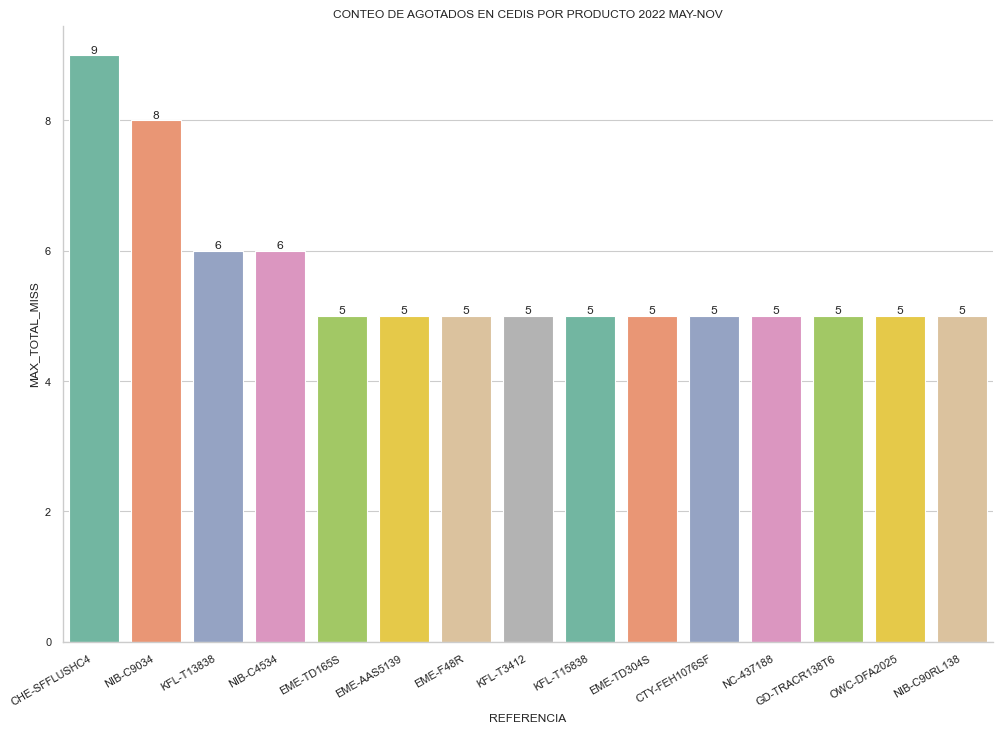

In [29]:
# top 15 missing products plot
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=0.9)
sns.set_palette("Set2", 15)
plt.subplots(figsize=(12, 8))
plt.title("CONTEO DE AGOTADOS EN CEDIS POR PRODUCTO 2022 MAY-NOV")
plot = sns.barplot(data=miss_freq_prod.head(15), x='REFERENCIA', y='MAX_TOTAL_MISS')
plot.bar_label(plot.containers[0], label_type='edge')
plt.setp(plot.get_xticklabels(), rotation=30, horizontalalignment="right")
sns.despine()